In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from flags_pennants import find_flags_pennants_pips, find_flags_pennants_trendline
    

# data = pd.read_csv('BTCUSDT3600.csv')
# data['date'] = data['date'].astype('datetime64[s]')

# ------ ES data -----
sdate = pd.Timestamp(2017,1,9,18,0).tz_localize('US/Eastern')
edate = pd.Timestamp(2020,12,13,16,0).tz_localize('US/Eastern')
pricedf = pd.read_parquet('D:\\futures_data\processed_data\ES_1min_continuous_adjusted_12-23.parquet') 
pricedf = pricedf[(pricedf.index >= sdate) & (pricedf.index < edate)]
candlelist = pricedf.copy()
candlelist['time'] = candlelist.index
candlelist = candlelist[['time','open','high','low','close','volume']].to_numpy()

from candlesticks import Candlesticks
bars = Candlesticks(2)
for candle in candlelist:
    bars.on_bar_update(candle)
data = pd.DataFrame(bars.bars, columns = ['date', 'open', 'high', 'low', 'close', 'volume'])
# --------------------

data = data.set_index('date')
data = np.log(data)
dat_slice = data['close'].to_numpy()


orders = list(range(20, 89))
bull_flag_wr = []
bull_pennant_wr = []
bear_flag_wr = []
bear_pennant_wr = []

bull_flag_avg = []
bull_pennant_avg = []
bear_flag_avg = []
bear_pennant_avg = []

bull_flag_count = []
bull_pennant_count = []
bear_flag_count = []
bear_pennant_count = []

bull_flag_total_ret = []
bull_pennant_total_ret = []
bear_flag_total_ret = []
bear_pennant_total_ret = []


for order in orders:
#     bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_pips(dat_slice, order)
    bull_flags, bear_flags, bull_pennants, bear_pennants  = find_flags_pennants_trendline(dat_slice, order)

    bull_flag_df = pd.DataFrame()
    bull_pennant_df = pd.DataFrame()
    bear_flag_df = pd.DataFrame()
    bear_pennant_df = pd.DataFrame()

    # Assemble data into dataframe
    hold_mult = 1.0 # Multipler of flag width to hold for after a pattern
    for i, flag in enumerate(bull_flags):
        bull_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bull_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bull_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bull_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bull_flag_df.loc[i, 'slope'] = flag.resist_slope

        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bull_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
            bull_flag_df.loc[i, 'return'] = ret 

    for i, flag in enumerate(bear_flags):
        bear_flag_df.loc[i, 'flag_width'] = flag.flag_width
        bear_flag_df.loc[i, 'flag_height'] = flag.flag_height
        bear_flag_df.loc[i, 'pole_width'] = flag.pole_width
        bear_flag_df.loc[i, 'pole_height'] = flag.pole_height
        bear_flag_df.loc[i, 'slope'] = flag.support_slope

        hp = int(flag.flag_width * hold_mult)
        if flag.conf_x + hp >= len(data):
            bear_flag_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
            bear_flag_df.loc[i, 'return'] = ret 

    for i, pennant in enumerate(bull_pennants):
        bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bull_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
            bull_pennant_df.loc[i, 'return'] = ret 

    for i, pennant in enumerate(bear_pennants):
        bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width
        bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height
        bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width
        bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height

        hp = int(pennant.flag_width * hold_mult)
        if pennant.conf_x + hp >= len(data):
            bear_pennant_df.loc[i, 'return'] = np.nan
        else:
            ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
            bear_pennant_df.loc[i, 'return'] = ret 

    if len(bull_flag_df) > 0:
        bull_flag_count.append(len(bull_flag_df))
        bull_flag_avg.append(bull_flag_df['return'].mean())
        bull_flag_wr.append(len(bull_flag_df[bull_flag_df['return'] > 0]) / len(bull_flag_df))
        bull_flag_total_ret.append(bull_flag_df['return'].sum())
    else:
        bull_flag_count.append(0)
        bull_flag_avg.append(np.nan)
        bull_flag_wr.append(np.nan)
        bull_flag_total_ret.append(0)
    
    if len(bear_flag_df) > 0:
        bear_flag_count.append(len(bear_flag_df))
        bear_flag_avg.append(bear_flag_df['return'].mean())
        bear_flag_wr.append(len(bear_flag_df[bear_flag_df['return'] > 0]) / len(bear_flag_df))
        bear_flag_total_ret.append(bear_flag_df['return'].sum())
    else:
        bear_flag_count.append(0)
        bear_flag_avg.append(np.nan)
        bear_flag_wr.append(np.nan)
        bear_flag_total_ret.append(0)
    
    if len(bull_pennant_df) > 0:
        bull_pennant_count.append(len(bull_pennant_df))
        bull_pennant_avg.append(bull_pennant_df['return'].mean())
        bull_pennant_wr.append(len(bull_pennant_df[bull_pennant_df['return'] > 0]) / len(bull_pennant_df))
        bull_pennant_total_ret.append(bull_pennant_df['return'].sum())
    else:
        bull_pennant_count.append(0)
        bull_pennant_avg.append(np.nan)
        bull_pennant_wr.append(np.nan)
        bull_pennant_total_ret.append(0)
    
    if len(bear_pennant_df) > 0:
        bear_pennant_count.append(len(bear_pennant_df))
        bear_pennant_avg.append(bear_pennant_df['return'].mean())
        bear_pennant_wr.append(len(bear_pennant_df[bear_pennant_df['return'] > 0]) / len(bear_pennant_df))
        bear_pennant_total_ret.append(bear_pennant_df['return'].sum())
    else:
        bear_pennant_count.append(0)
        bear_pennant_avg.append(np.nan)
        bear_pennant_wr.append(np.nan)
        bear_pennant_total_ret.append(0)
    

results_df = pd.DataFrame(index=orders)
results_df['bull_flag_count'] = bull_flag_count
results_df['bull_flag_avg'] = bull_flag_avg
results_df['bull_flag_wr'] = bull_flag_wr
results_df['bull_flag_total'] = bull_flag_total_ret

results_df['bear_flag_count'] = bear_flag_count
results_df['bear_flag_avg'] = bear_flag_avg
results_df['bear_flag_wr'] = bear_flag_wr
results_df['bear_flag_total'] = bear_flag_total_ret

results_df['bull_pennant_count'] = bull_pennant_count
results_df['bull_pennant_avg'] = bull_pennant_avg
results_df['bull_pennant_wr'] = bull_pennant_wr
results_df['bull_pennant_total'] = bull_pennant_total_ret

results_df['bear_pennant_count'] = bear_pennant_count
results_df['bear_pennant_avg'] = bear_pennant_avg
results_df['bear_pennant_wr'] = bear_pennant_wr
results_df['bear_pennant_total'] = bear_pennant_total_ret



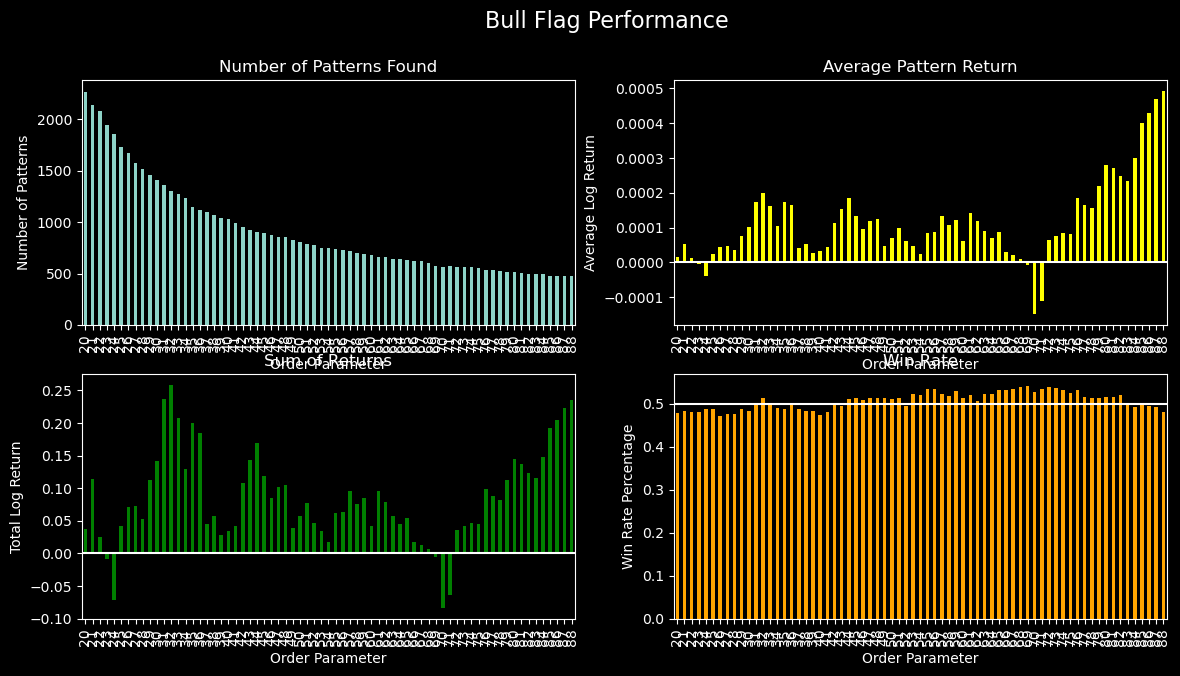

In [2]:
# Plot bull flag results
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14,7)
fig.suptitle("Bull Flag Performance", fontsize=16)
results_df['bull_flag_count'].plot.bar(ax=ax[0,0])
results_df['bull_flag_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bull_flag_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bull_flag_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')

plt.show()



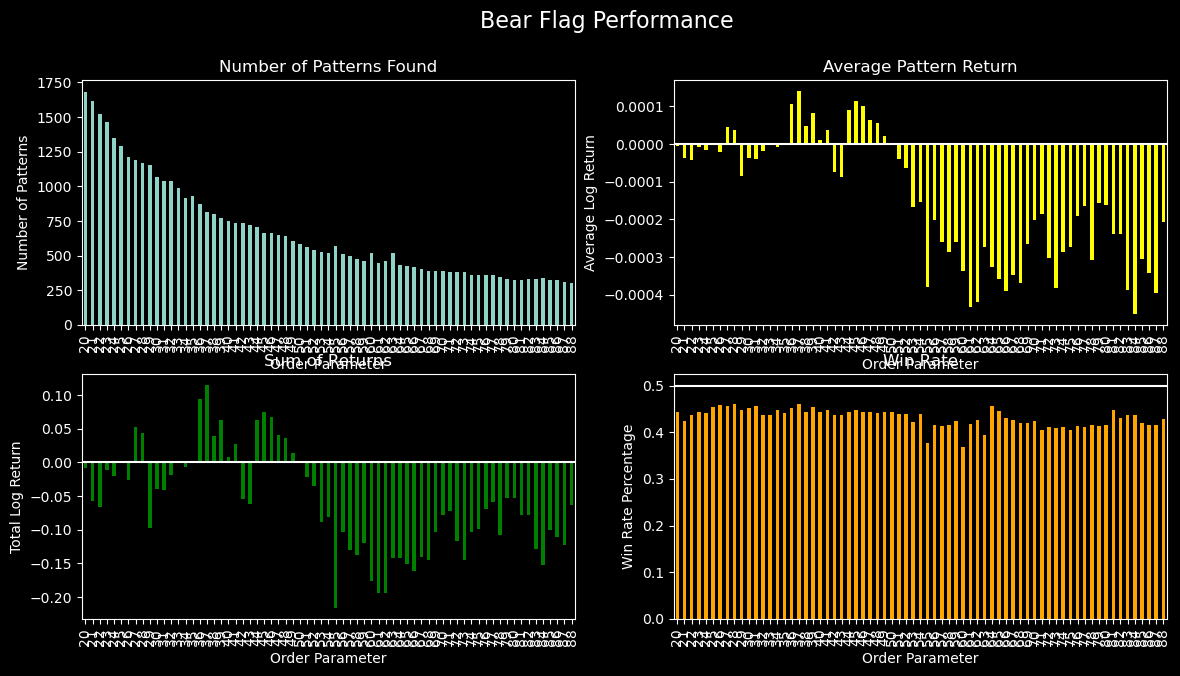

In [3]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14,7)
fig.suptitle("Bear Flag Performance", fontsize=16)
results_df['bear_flag_count'].plot.bar(ax=ax[0,0])
results_df['bear_flag_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bear_flag_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bear_flag_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()



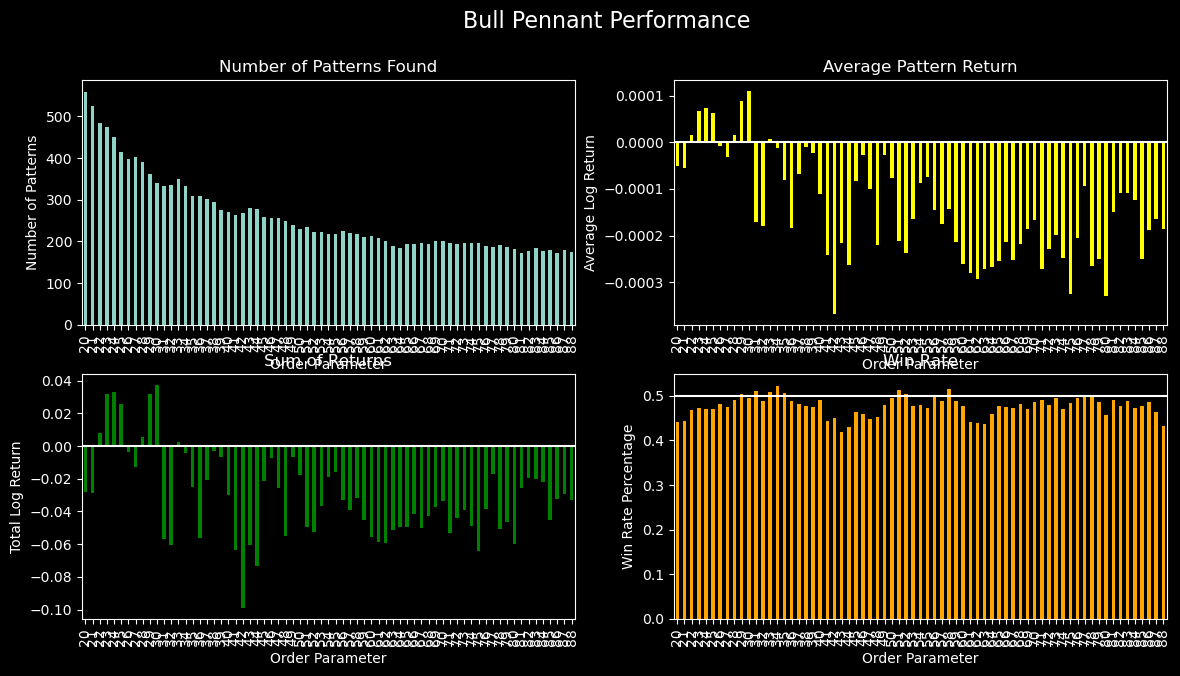

In [4]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14,7)
fig.suptitle("Bull Pennant Performance", fontsize=16)
results_df['bull_pennant_count'].plot.bar(ax=ax[0,0])
results_df['bull_pennant_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bull_pennant_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bull_pennant_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()



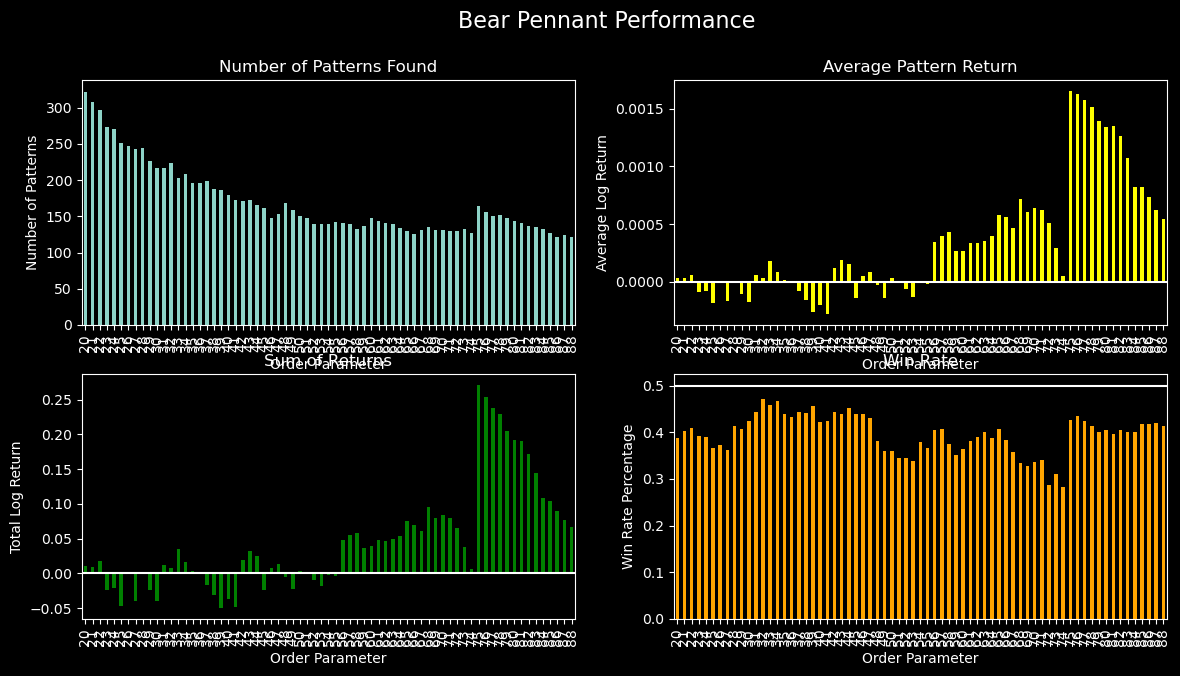

In [5]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14,7)
fig.suptitle("Bear Pennant Performance", fontsize=16)
results_df['bear_pennant_count'].plot.bar(ax=ax[0,0])
results_df['bear_pennant_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['bear_pennant_total'].plot.bar(ax=ax[1,0], color='green')
results_df['bear_pennant_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()